In [7]:
import os, re, laspy
import numpy as np
import pandas as pd
from datetime import datetime
import io
from pathlib import Path
DATA_LAZ_DIR = Path("../raw_data/kijkduin_hourly/pointclouds")  # your folder in the screenshot
METEO_CSV    = Path("../raw_data/kijkduin_hourly/supplementary/KNMI_201611_201705_hourly_330_hoekvanholland_formatted.csv")     
# Spatial gridding (choose a manageable AOI for speed)
GRID_RES_M   = 1.0           # DEM grid resolution
KNN_K        = 8             # graph neighborhood
SEQ_LEN      = 12            # use past 12 hours
HORIZONS     = [6, 12, 24]   # predict 6/12/24h ahead
COAST_AZIMUT = 270           # onshore azimuth (deg, 270≈west; adjust if your coastline differs)
EROSION_THR  = -0.005        # 0.5 cm Δz threshold over horizon

RANDOM_SEED  = 42

# data & feature

In [13]:
# Cell 3 — read .laz → numpy, then grid to DEM
import re, laspy, numpy as np
from tqdm import tqdm

def parse_ts(fname:str):
    # e.g. kijkduin_170117_120041.laz => 2017-01-17 12:00:41
    m = re.search(r"_(\d{6})_(\d{6})", fname)
    d, t = m.groups()
    return pd.to_datetime(d+t, format="%y%m%d%H%M%S")

# discover files
laz_files = sorted([p for p in DATA_LAZ_DIR.glob("kijkduin_*.laz")])
print(f"found {len(laz_files)} files")

# quick scan to get AOI bbox
def read_points(laz_path:Path):
    las = laspy.read(laz_path)
    return np.vstack([las.x, las.y, las.z]).T

# compute common bbox from a sample (to keep notebook runtime sensible, use first 50 files)
SAMPLE_MAX = min(50, len(laz_files))
pts_sample = np.vstack([read_points(lf) for lf in laz_files[:SAMPLE_MAX]])
xmin,ymin = pts_sample[:,:2].min(axis=0)
xmax,ymax = pts_sample[:,:2].max(axis=0)

# make fixed grid
xi = np.arange(xmin, xmax, GRID_RES_M)
yi = np.arange(ymin, ymax, GRID_RES_M)
nx, ny = len(xi), len(yi)

def to_dem(points):
    # bin by nearest grid cell, take mean z
    ix = np.clip(((points[:,0]-xmin)/GRID_RES_M).astype(int), 0, nx-1)
    iy = np.clip(((points[:,1]-ymin)/GRID_RES_M).astype(int), 0, ny-1)
    zgrid = np.full((ny, nx), np.nan, dtype=np.float32)
    counts = np.zeros_like(zgrid, dtype=np.int32)
    for xg, yg, z in zip(ix, iy, points[:,2]):
        zgrid[yg, xg] = np.nanmean([zgrid[yg, xg], z]) if not np.isnan(zgrid[yg, xg]) else z
        counts[yg, xg] += 1
    # simple hole fill: nearest valid
    mask = np.isnan(zgrid)
    if mask.any():
        from scipy.ndimage import distance_transform_edt
        yy, xx = np.indices(zgrid.shape)
        dist, (yy0, xx0) = distance_transform_edt(mask, return_indices=True)
        zgrid = zgrid[yy0, xx0]
    return zgrid

# read, grid and time-stamp all DEMs
dem_ts = []
for lf in tqdm(laz_files[:SAMPLE_MAX]):
    Z = to_dem(read_points(lf))
    dem_ts.append((parse_ts(lf.name), Z))
dem_ts = sorted(dem_ts, key=lambda x: x[0])
print(f"gridded DEMs: {len(dem_ts)}; grid size={ny}×{nx}")


found 51 files


100%|██████████| 50/50 [02:21<00:00,  2.83s/it]

gridded DEMs: 50; grid size=471×209


In [24]:
dem_ts[0][1].shape

(471, 209)

In [12]:
# files = sorted([f for f in os.listdir(DATA_LAZ_DIR) if f.endswith(".laz")])

# def parse_timestamp(filename):
#     # e.g. kijkduin_170117_120041.laz → 2017-01-17 12:00:41
#     date_str = re.search(r"_(\d{6})_(\d{6})", filename)
#     d, t = date_str.groups()
#     return datetime.strptime(d + t, "%y%m%d%H%M%S")

# data_list = []

# for f in files:
#     timestamp = parse_timestamp(f)
#     path = os.path.join(folder, f)
#     las = laspy.read(path)
#     xyz = np.vstack((las.x, las.y, las.z)).T
#     df = pd.DataFrame(xyz, columns=["x", "y", "z"])
#     df["timestamp"] = timestamp
#     data_list.append(df)

# # Combine into one DataFrame (the 4D dataset)
# pc_4d = pd.concat(data_list, ignore_index=True)
# pc_4d

,x,y,z,timestamp
0,-240.41250,-29.42850,-37.80900,2017-01-17 12:00:41
1,-240.27375,-28.77525,-37.80500,2017-01-17 12:00:41
2,-240.05400,-27.03525,-37.78725,2017-01-17 12:00:41
3,-240.79400,-26.70250,-37.79650,2017-01-17 12:00:41
4,-239.69200,-26.80325,-37.78025,2017-01-17 12:00:41
...,...,...,...,...
10993045,-34.29225,-298.51075,-24.37775,2017-01-19 14:01:21
10993046,-34.20400,-299.78475,-24.21775,2017-01-19 14:01:21
10993047,-34.29225,-298.51075,-24.37775,2017-01-19 14:01:21
10993048,-34.14925,-299.30275,-24.44075,2017-01-19 14:01:21


In [41]:
path = "../raw_data/kijkduin_hourly/supplementary/KNMI_201611_201705_hourly_330_hoekvanholland_formatted.csv"
knmi = pd.read_csv(path)

# Assume knmi is your dataframe with 'YYYYMMDD' and 'HH'
knmi['YYYYMMDD'] = knmi['YYYYMMDD'].astype(int)
knmi['HH'] = knmi['HH'].astype(int)

# Split rows where HH == 24
mask_24 = knmi['HH'] == 24

# For HH == 24 → increment date by one day, reset hour to 0
knmi.loc[mask_24, 'YYYYMMDD'] = (
    pd.to_datetime(knmi.loc[mask_24, 'YYYYMMDD'].astype(str), format='%Y%m%d')
    + pd.Timedelta(days=1)
).dt.strftime('%Y%m%d').astype(int)
knmi.loc[mask_24, 'HH'] = 0

# Now safely convert to datetime
knmi['YYYYMMDD'] = knmi['YYYYMMDD'].astype(str)
knmi['HH'] = knmi['HH'].astype(int).astype(str).str.zfill(2)
knmi['datetime'] = pd.to_datetime(knmi['YYYYMMDD'] + knmi['HH'], format='%Y%m%d%H')

# Set as index
knmi = knmi.set_index('datetime').sort_index()
print(knmi.index[:5])

# Unit conversions (per KNMI meta)
# wind speeds in 0.1 m/s → m/s; temperature & dew point in 0.1 °C → °C; pressure 0.1 hPa → hPa
for col in ['FH','FF','FX','T','TD','P']:
    if col in knmi.columns:
        knmi[col] = knmi[col] / (10.0 if col!='P' else 10.0)

# RH in table is rainfall (0.1 mm) — keep as rain_mm
if 'RH' in knmi.columns:
    knmi.rename(columns={'RH':'RAIN_01MM'}, inplace=True)
    knmi['RAIN_mm'] = knmi['RAIN_01MM'] / 10.0

# radiation Q: J/cm^2 per hour  →  W/m^2  (1 J/cm^2 = 10,000 J/m^2; per hour => divide by 3600)
if 'Q' in knmi.columns:
    knmi['SWdown_Wm2'] = knmi['Q'].fillna(0.0) * (10000.0/3600.0)

# Relative humidity is 'U' (%) already; wind direction 'DD' (deg, from-where)
# Build wind components (meteorological to math: u = -FF*sinθ, v = -FF*cosθ)
theta = np.deg2rad(knmi['DD'].fillna(0.0))
ff    = knmi['FF'].fillna(0.0)
knmi['u'] = -ff*np.sin(theta)
knmi['v'] = -ff*np.cos(theta)

# Onshore unit vector (coast azimuth points to sea→shore; wind is from-where, so use -direction)
coast_rad      = np.deg2rad(COAST_AZIMUT)
onshore_vec    = np.array([np.cos(coast_rad), np.sin(coast_rad)])
wind_vec       = np.stack([knmi['u'].values, knmi['v'].values], axis=1)
knmi['U_eff']  = (wind_vec @ onshore_vec)  # positive when blowing onshore (effective shear component)
# knmi = knmi.set_index('dt').sort_index()

# A few lags/rolls (help temporal models)
for h in [1,3,6]:
    knmi[f'U_eff_roll{h}'] = knmi['U_eff'].rolling(h, min_periods=1).mean()
    knmi[f'RAIN_sum{h}']   = knmi['RAIN_mm'].rolling(h, min_periods=1).sum()
knmi.head(5).T

DatetimeIndex(['2016-10-01 01:00:00', '2016-10-01 02:00:00',
               '2016-10-01 03:00:00', '2016-10-01 04:00:00',
               '2016-10-01 05:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


datetime,2016-10-01 01:00:00,2016-10-01 02:00:00,2016-10-01 03:00:00,2016-10-01 04:00:00,2016-10-01 05:00:00
STN,330,330,330,330,330
YYYYMMDD,20161001,20161001,20161001,20161001,20161001
HH,01,02,03,04,05
DD,180,190,160,170,170
FH,6.0,5.0,5.0,5.0,6.0
FF,7.0,5.0,5.0,5.0,6.0
FX,8.0,7.0,6.0,7.0,8.0
T,14.0,12.9,12.6,12.0,12.1
T10,NaN,NaN,NaN,NaN,NaN
TD,11.4,11.2,11.2,11.1,11.1


In [47]:
# When iterating over DEMs
for t, Z in dem_ts:
    t_hour = t.floor('H')  # or t.round('H')
dem_ts = 
#     env = knmi.loc[t_hour, ['T','U_eff','RAIN_sum3','SWdown_Wm2','P']].to_numpy(dtype=np.float32)

/tmp/ipykernel_3090/1373516188.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_hour = t.floor('H')  # or t.round('H')


In [49]:
dem_ts

[(Timestamp('2017-01-17 12:00:41'),
  array([[-38.618   , -38.618   , -38.618   , ..., -23.838968, -23.70975 ,
          -23.63425 ],
         [-38.61    , -38.61    , -38.61    , ..., -24.1985  , -23.928125,
          -23.928125],
         [-38.61    , -38.61    , -38.61    , ..., -24.168   , -24.171095,
          -24.171095],
         ...,
         [-36.715   , -36.715   , -36.706   , ..., -24.038   , -24.038   ,
          -24.038   ],
         [-36.689   , -36.689   , -36.689   , ..., -24.038   , -24.038   ,
          -24.038   ],
         [-36.689   , -36.689   , -36.689   , ..., -24.038   , -24.038   ,
          -24.038   ]], dtype=float32)),
 (Timestamp('2017-01-17 13:00:42'),
  array([[-38.63925 , -38.63925 , -38.63925 , ..., -23.7075  , -23.635813,
          -23.63975 ],
         [-38.63925 , -38.63925 , -38.63925 , ..., -24.109327, -23.977   ,
          -23.977   ],
         [-38.63925 , -38.63925 , -38.63925 , ..., -24.211874, -24.03625 ,
          -24.03625 ],
         ...,


In [48]:
dem_ts

[(Timestamp('2017-01-17 12:00:41'),
  array([[-38.618   , -38.618   , -38.618   , ..., -23.838968, -23.70975 ,
          -23.63425 ],
         [-38.61    , -38.61    , -38.61    , ..., -24.1985  , -23.928125,
          -23.928125],
         [-38.61    , -38.61    , -38.61    , ..., -24.168   , -24.171095,
          -24.171095],
         ...,
         [-36.715   , -36.715   , -36.706   , ..., -24.038   , -24.038   ,
          -24.038   ],
         [-36.689   , -36.689   , -36.689   , ..., -24.038   , -24.038   ,
          -24.038   ],
         [-36.689   , -36.689   , -36.689   , ..., -24.038   , -24.038   ,
          -24.038   ]], dtype=float32)),
 (Timestamp('2017-01-17 13:00:42'),
  array([[-38.63925 , -38.63925 , -38.63925 , ..., -23.7075  , -23.635813,
          -23.63975 ],
         [-38.63925 , -38.63925 , -38.63925 , ..., -24.109327, -23.977   ,
          -23.977   ],
         [-38.63925 , -38.63925 , -38.63925 , ..., -24.211874, -24.03625 ,
          -24.03625 ],
         ...,


In [51]:
import numpy as np
from scipy.ndimage import sobel

def topo_features(Z):
    dzdx = sobel(Z, axis=1) / 8.0
    dzdy = sobel(Z, axis=0) / 8.0
    slope = np.hypot(dzdx, dzdy)
    aspect = np.arctan2(dzdy, dzdx)
    curvature = sobel(dzdx, axis=1) / 8.0 + sobel(dzdy, axis=0) / 8.0
    roughness = np.sqrt(dzdx**2 + dzdy**2)
    return slope, aspect, curvature, roughness

# Assuming dem_list = list of (datetime, DEM) tuples
spatial_feats = []
for t, Z in dem_ts:
    # ✅ round to hour to match KNMI
    t_aligned = pd.Timestamp(t).floor('h')

    # compute topographic features
    slope, aspect, curv, rough = topo_features(Z)

    # safely fetch environmental drivers (after rounding)
    if t_aligned in knmi.index:
        env = knmi.loc[t_aligned, ['T','U_eff','RAIN_sum3','SWdown_Wm2','P']].to_numpy(dtype=np.float32)
    else:
        # fallback if still missing
        env = knmi.iloc[(knmi.index - t_aligned).abs().argmin()][['T','U_eff','RAIN_sum3','SWdown_Wm2','P']].to_numpy(dtype=np.float32)

    env_tiled = np.tile(env[:, None, None], (1, *Z.shape))
    stacked = np.stack([Z, slope, curv, rough, *env_tiled], axis=0)
    spatial_feats.append((t_aligned, stacked))


/tmp/ipykernel_3090/2538063710.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_aligned = pd.Timestamp(t).floor('H')
/tmp/ipykernel_3090/2538063710.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_aligned = pd.Timestamp(t).floor('H')
/tmp/ipykernel_3090/2538063710.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_aligned = pd.Timestamp(t).floor('H')
/tmp/ipykernel_3090/2538063710.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_aligned = pd.Timestamp(t).floor('H')
/tmp/ipykernel_3090/2538063710.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_aligned = pd.Timestamp(t).floor('H')
/tmp/ipykernel_3090/2538063710.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, ple

In [54]:
# Build a fixed 8-neighbor graph once (node IDs are stable across time)
import numpy as np
import torch
from torch_geometric.data import Data

# infer H, W, C from first slice
t0, X0 = spatial_feats[0]
C, H, W = X0.shape
N = H * W

yy, xx = np.indices((H, W))
xy = np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)

edges = []
for y in range(H):
    for x in range(W):
        nid = y*W + x
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y2, x2 = y+dy, x+dx
                if 0<=y2<H and 0<=x2<W:
                    edges.append([nid, y2*W+x2])
edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)  # [2, E]

def to_graph_timestep(X_t):   # X_t: [C,H,W]
    x = torch.tensor(X_t.reshape(C, -1).T, dtype=torch.float32)  # [N, C]
    return Data(x=x, edge_index=edge_index)

In [58]:
xy.shape

(98439, 2)

In [56]:
edge_index.shape # roughly xy.shape * 8 (directions)

torch.Size([2, 783436])

In [59]:
# Build sequences of length SEQ_LEN and targets at future horizons
import pandas as pd

SEQ_LEN   = 12
HORIZONS  = [6, 12, 24]   # hours ahead
times     = [t for t,_ in spatial_feats]
Xt        = [X for _,X in spatial_feats]  # [T, C, H, W]
Zt        = [X[0] for X in Xt]            # Z is channel 0

X_seq, Y_targets, t_index = [], {h: [] for h in HORIZONS}, []
for idx in range(SEQ_LEN, len(times)-max(HORIZONS)):
    # inputs: past SEQ_LEN feature tensors
    X_seq.append(np.stack(Xt[idx-SEQ_LEN:idx], axis=0))  # [SEQ_LEN, C, H, W]
    t_index.append(times[idx])                           # reference time
    # targets: Δz between now and future horizon
    Z_now = Zt[idx]
    for h in HORIZONS:
        Y_targets[h].append((Zt[idx+h] - Z_now).astype(np.float32))

X_seq      = np.stack(X_seq)                              # [N, T, C, H, W]
Y_targets  = {h: np.stack(Y_targets[h]) for h in HORIZONS}# [N, H, W]
Nseq = X_seq.shape[0]
print("Prepared:", X_seq.shape, {h:v.shape for h,v in Y_targets.items()})


Prepared: (14, 12, 9, 471, 209) {6: (14, 471, 209), 12: (14, 471, 209), 24: (14, 471, 209)}


In [62]:
Xt[0].shape

(9, 471, 209)

| Channel | Symbol     | Meaning                          | Source               | Units / Scale |
| :------ | :--------- | :------------------------------- | :------------------- | :------------ |
| 0       | Z          | Surface elevation                | DEM                  | metres        |
| 1       | Slope      | Gradient magnitude               | derived from DEM     | m/m           |
| 2       | Curvature  | Local convexity/concavity        | derived from DEM     | 1/m           |
| 3       | Roughness  | Microrelief / textural variation | derived from DEM     | m             |
| 4       | T          | Air temperature                  | KNMI                 | °C            |
| 5       | U_eff      | Effective onshore wind           | KNMI (m/s projected) | m/s           |
| 6       | RAIN_sum3  | 3 h accumulated rainfall         | KNMI                 | mm            |
| 7       | SWdown_Wm2 | Shortwave solar radiation        | KNMI                 | W m⁻²         |
| 8       | P          | Air pressure                     | KNMI                 | hPa           |

Why this matters for ST-GUNet

Channels 0–3 (topography): encode geometry-driven susceptibility (e.g., steep slopes → sand loss).

Channels 4–8 (climate forcing): encode external drivers of erosion and deposition.

Together, they allow ST-GUNet to learn how physical forcing interacts with morphology over time — i.e., when and where dunes erode under specific weather patterns.

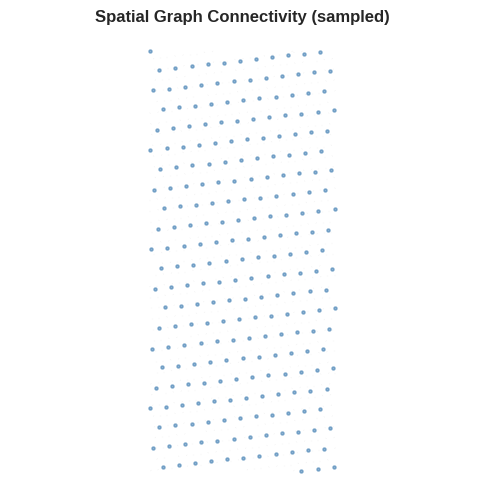

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# sample only a portion to keep the figure clean
H, W = 471, 209
yy, xx = np.indices((H, W))
nodes = np.stack([xx.ravel(), yy.ravel()], axis=1)
edge_sample = edge_index[:, ::800]  # sample ~1/800th of edges

plt.figure(figsize=(6, 6))
plt.style.use('seaborn-v0_8-white')

# plot edges as faint gray lines
for s, t in edge_sample.T:
    x0, y0 = nodes[s]
    x1, y1 = nodes[t]
    plt.plot([x0, x1], [y0, y1], color='lightgray', lw=0.3, alpha=0.4)

# plot nodes as small dots
plt.scatter(nodes[::400,0], nodes[::400,1], s=5, color='steelblue', alpha=0.6)

plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')
plt.title("Spatial Graph Connectivity (sampled)", fontsize=12, weight='semibold')
plt.show()


# Model

In [101]:
import torch.nn as nn
from torch_geometric.nn import GraphUNet
from torch.utils.data import Dataset, DataLoader
import math, numpy as np

class STGUNet(nn.Module):
    def __init__(self, in_ch: int, hidden: int=64, depth:int=3, quantiles=(0.1,0.5,0.9)):
        super().__init__()
        self.quantiles = quantiles
        self.gunet   = GraphUNet(in_ch, hidden, hidden, depth=depth)
        self.temporal = nn.GRU(hidden, hidden, batch_first=True)   # across time
        self.heads   = nn.ModuleDict({ f"q{int(q*100)}": nn.Linear(hidden,1) for q in quantiles })
        self.act     = nn.ReLU()

    def forward(self, seq_graphs):
        feats = []
        for g in seq_graphs:                          # each g: Data with .x [N,in_ch], .edge_index
            z = self.gunet(g.x, g.edge_index)         # [N, hidden]
            feats.append(self.act(z))
        X = torch.stack(feats, dim=1)                 # [N, T, hidden]
        Y, _ = self.temporal(X)                       # [N, T, hidden]
        Hlast = Y[:, -1, :]                           # [N, hidden]
        return {k: head(Hlast).squeeze(1) for k, head in self.heads.items()}  # dict of [N]

def pinball(pred, target, q):
    diff = target - pred
    return torch.mean(torch.maximum(q*diff, (q-1)*diff))

def physics_hinge(pred, U_eff_value, RH_value):
    """
    Penalize erosion (<0) when effective wind is below humidity-adjusted threshold.
    U_thr = a (+b if RH>80). pred is Δz (m). Negative = erosion.
    """
    a, b = 6.0, 2.0  # m/s
    U_thr = a + (b if RH_value>80 else 0.0)
    weak = max(U_thr - U_eff_value, 0.0)
    erosion_mag = torch.clamp(-pred, min=0.0)
    return (weak * erosion_mag).mean()


# Load data

class SeqGraphDataset(Dataset):
    def __init__(self, X_seq, Y_targets, edge_index):
        self.X_seq = X_seq
        self.Y     = Y_targets
        self.edge_index = edge_index
    def __len__(self): return len(self.X_seq)
    def __getitem__(self, i):
        seq = [ to_graph_timestep(self.X_seq[i,t]) for t in range(self.X_seq.shape[1]) ]  # list[Data]
        ys  = {h: torch.tensor(self.Y[h][i].reshape(-1), dtype=torch.float32) for h in self.Y.keys()}
        return seq, ys

# split by time
n_train = int(0.8*Nseq)
train_ds = SeqGraphDataset(X_seq[:n_train], {h:Y_targets[h][:n_train] for h in HORIZONS}, edge_index)
test_ds  = SeqGraphDataset(X_seq[n_train:], {h:Y_targets[h][n_train:] for h in HORIZONS}, edge_index)

def collate(batch):
    # list of (seq_graphs, ys) → as is (we iterate items inside loop)
    return batch

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, collate_fn=collate)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_STGUNet  = STGUNet(in_ch=C, hidden=64, depth=3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)


In [106]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# --- Config ---
EPOCHS = 10
warmup_epochs = 2
best_val = float('inf')
patience, wait = 10, 0
base_lr = 5e-4
lambda_phys = 0.1

optimizer = torch.optim.Adam(model_STGUNet.parameters(), lr=base_lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, factor=0.5, verbose=True)

print("Starting training of STGUNet...\n")
for epoch in range(EPOCHS):
    # ---- Warmup ----
    if epoch < warmup_epochs:
        lr = 1e-5 + (epoch / warmup_epochs) * base_lr
        for g in optimizer.param_groups: g['lr'] = lr

    # ---- Training ----
    model_STGUNet.train()
    train_pinball, train_phys = 0., 0.
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        (seq, ys) = batch[0]   # batch is a list of 1 tuple
        seq = [g.to(device) for g in seq]
        ys  = {h: y.to(device) for h, y in ys.items()}

        outs = model_STGUNet(seq)
        losses = []
        for h in HORIZONS:
            y_true = ys[h]
            for k,q in [('q10',0.1),('q50',0.5),('q90',0.9)]:
                losses.append(pinball(outs[k], y_true, q))

        # physics prior
        U_eff_value = float(knmi.iloc[-1]['U_eff'])
        RH_value    = float(knmi.iloc[-1]['U']) if 'U' in knmi.columns else 75.0
        L_phys = physics_hinge(outs['q50'], U_eff_value, RH_value)
        loss_pinball = torch.stack(losses).mean()
        loss = loss_pinball + lambda_phys * L_phys

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_pinball += loss_pinball.item()
        train_phys += L_phys.item()

    # ---- Validation ----
    model_STGUNet.eval()
    val_pinball, val_phys = 0., 0.
    with torch.no_grad():
        for batch in test_loader:
            (seq, ys) = batch[0]
            seq = [g.to(device) for g in seq]
            ys  = {h:y.to(device) for h,y in ys.items()}
            outs = model_STGUNet(seq)
            losses = []
            for h in HORIZONS:
                y_true = ys[h]
                for k,q in [('q10',0.1),('q50',0.5),('q90',0.9)]:
                    losses.append(pinball(outs[k], y_true, q))
            U_eff_value = float(knmi.iloc[-1]['U_eff'])
            RH_value    = float(knmi.iloc[-1]['U']) if 'U' in knmi.columns else 75.0
            val_pinball += torch.stack(losses).mean().item()
            val_phys += physics_hinge(outs['q50'], U_eff_value, RH_value).item()

    # ---- Logging ----
    val_loss = val_pinball + lambda_phys * val_phys
    print(f"Epoch {epoch+1:03d} | train_pin={train_pinball/len(train_loader):.4f} "
          f"| val_pin={val_pinball/len(test_loader):.4f} "
          f"| val_phys={val_phys/len(test_loader):.4f}")

    scheduler.step(val_loss)

    # ---- Early stopping ----
    if val_loss < best_val:
        best_val = val_loss
        wait = 0
        torch.save(model_STGUNet.state_dict(), "stgunet_best.pt")
    else:
        wait += 1
        if wait >= patience:
            print("🛑 Early stopping triggered")
            break


Starting training of STGUNet...



Epoch 001 | train_pin=0.3645 | val_pin=0.2824 | val_phys=3.8972


Epoch 002 | train_pin=0.2781 | val_pin=0.0789 | val_phys=0.1492


Epoch 003 | train_pin=0.1483 | val_pin=0.0487 | val_phys=0.0000


Epoch 004 | train_pin=0.1209 | val_pin=0.0394 | val_phys=0.0000


Epoch 005 | train_pin=0.1160 | val_pin=0.0375 | val_phys=0.0000


Epoch 006 | train_pin=0.1145 | val_pin=0.0329 | val_phys=0.0316


Epoch 007 | train_pin=0.1104 | val_pin=0.0310 | val_phys=0.0208


Epoch 008 | train_pin=0.1086 | val_pin=0.0294 | val_phys=0.0236


Epoch 009 | train_pin=0.1068 | val_pin=0.0276 | val_phys=0.0126


Epoch 010 | train_pin=0.1056 | val_pin=0.0268 | val_phys=0.0047


In [128]:
import torch

# Load best checkpoint
model_STGUNet.load_state_dict(torch.load("stgunet_best.pt"))
model_STGUNet.train()

# Pick one representative sequence
(seq, _) = test_ds[0]
seq = [g.to(device) for g in seq]

# Compute gradient-based saliency
for g in seq:
    g.x.requires_grad_(True)

outs = model_STGUNet(seq)
target = outs['q50'].mean()
target.backward()

saliency = [g.x.grad.abs().mean(dim=0).cpu().numpy() for g in seq]
saliency_mean = np.mean(np.stack(saliency), axis=0)
feature_names = ["Z", "Slope", "Curvature", "Roughness", "T", "U_eff", "Rain_sum3", "SWdown", "P"]

print("\nFeature sensitivity (∂Δz/∂feature):")
for name, s in zip(feature_names, saliency_mean):
    print(f"{name:10s}: {s:.4f}")


/tmp/ipykernel_3090/3651579619.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_STGUNet.load_state_dict(torch.load("stgunet_best.pt"))



Feature sensitivity (∂Δz/∂feature):
Z         : 0.0000
Slope     : 0.0000
Curvature : 0.0000
Roughness : 0.0000
T         : 0.0000
U_eff     : 0.0000
Rain_sum3 : 0.0000
SWdown    : 0.0000
P         : 0.0000


In [146]:
import numpy as np

# Evaluate on horizon=6h using median head
HSEL = 6
model.eval()
preds, trues = [], []
with torch.no_grad():
    for batch in test_loader:
        (seq, ys) = batch[0]
        seq = [g.to(device) for g in seq]
        out = model(seq)['q50'].cpu().numpy().reshape(H, W)
        preds.append(out)
        trues.append(ys[HSEL].numpy().reshape(H, W))
preds = np.stack(preds)  # [Ntest,H,W]
trues = np.stack(trues)

rmse = np.sqrt(np.mean((preds - trues)**2))
print("RMSE Δz @+6h (m):", rmse)

# Risk map for last test sample
EROSION_THR = -0.005  # 0.5 cm
risk = (preds[-1] < EROSION_THR).astype(np.uint8)

# Action list: top-k most negative Δz cells
k = 30
flat = preds[-1].ravel()
order = np.argsort(flat)[:k]  # most negative first
actions = [(int(i//W), int(i%W), float(flat[i])) for i in order]

print("Top-k action cells (row, col, Δz[m]):")
for r in actions[:10]:
    print(r)


RMSE Δz @+6h (m): 0.14861876
Top-k action cells (row, col, Δz[m]):
(117, 0, -0.04364848509430885)
(0, 0, -0.01098128966987133)
(116, 208, -0.010575948283076286)
(117, 158, -0.009968226775527)
(235, 208, -0.007828539237380028)
(0, 208, -0.007266243454068899)
(235, 205, -0.0053539699874818325)
(235, 204, -0.00498989736661315)
(117, 159, -0.004972075577825308)
(235, 203, -0.0048110163770616055)


In [148]:
# baselines
# Compute persistence baseline RMSE (predict Δz=0)
baseline_rmse = np.sqrt(np.mean(trues**2))
print(f"Persistence baseline RMSE Δz @+6h: {baseline_rmse:.4f} m")

# Optionally: constant mean baseline
mean_pred = np.mean(trues)
mean_rmse = np.sqrt(np.mean((trues - mean_pred)**2))
print(f"Mean baseline RMSE: {mean_rmse:.4f} m")


Persistence baseline RMSE Δz @+6h: 0.1487 m
Mean baseline RMSE: 0.1484 m


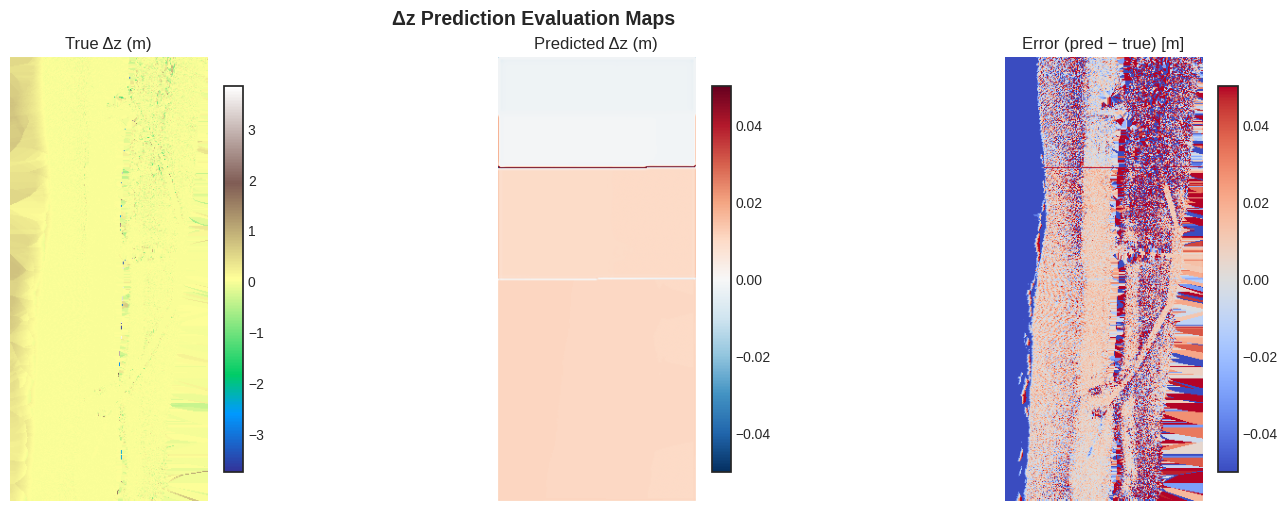

In [149]:
Z_true = trues[-1]
Z_pred = preds[-1]          # <- use preds
err    = Z_pred - Z_true

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# True Δz
im0 = axes[0].imshow(Z_true, cmap="terrain")
axes[0].set_title("True Δz (m)")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Predicted Δz
im1 = axes[1].imshow(Z_pred, cmap="RdBu_r", vmin=-0.05, vmax=0.05)
axes[1].set_title("Predicted Δz (m)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Error (pred − true)
err = Z_pred - Z_true
im2 = axes[2].imshow(err, cmap="coolwarm", vmin=-0.05, vmax=0.05)
axes[2].set_title("Error (pred − true) [m]")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

for ax in axes:
    ax.axis("off")

plt.suptitle("Δz Prediction Evaluation Maps", fontsize=14, fontweight="semibold")
plt.show()


1. is the split between train and test influenced by time?
2. What does pinball mean? can we print in each epoch both loss terms? Can we validate on the test during each epoch and prnit loss for it? Would this require splitting conditioned on time? What's the best way if not?
2. can we add warming up and early stopping, what is optimiser, can we adjust lr in the training?

# XGBoost baseline

In [150]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Flatten your tensors ---
# X_seq: [Nseq, T, C, H, W]   Y_targets: dict of Δz at horizon
# Example: horizon = +6h (Y_targets['+6h'])
X_flat, y_flat = [], []
for t in range(X_seq.shape[0]):
    X_t = X_seq[t, -1]            # last frame of sequence
    y_t = Y_targets[6][t]     # matching target
    n = X_t.shape[1] * X_t.shape[2]
    X_flat.append(X_t.reshape(X_t.shape[0], -1).T)  # (n_cells, C)
    y_flat.append(y_t.reshape(-1))                   # (n_cells,)
    
X_flat = np.concatenate(X_flat, axis=0)
y_flat = np.concatenate(y_flat, axis=0)

# Remove NaNs
mask = np.isfinite(y_flat)
X_flat, y_flat = X_flat[mask], y_flat[mask]

print("X_flat shape:", X_flat.shape)
print("y_flat shape:", y_flat.shape)


X_flat shape: (1378146, 9)
y_flat shape: (1378146,)


In [151]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Flatten your 4D sequences into tabular samples
X_flat, y_flat = [], []
for t in range(X_seq.shape[0]):
    X_t = X_seq[t, -1]             # last timestep features, shape [C, H, W]
    y_t = Y_targets[6][t]      # Δz target for +6h horizon
    X_flat.append(X_t.reshape(X_t.shape[0], -1).T)
    y_flat.append(y_t.reshape(-1))

X_flat = np.concatenate(X_flat, axis=0)
y_flat = np.concatenate(y_flat, axis=0)

mask = np.isfinite(y_flat)
X_flat, y_flat = X_flat[mask], y_flat[mask]
print("X_flat:", X_flat.shape, "y_flat:", y_flat.shape)


X_flat: (1378146, 9) y_flat: (1378146,)


In [152]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X_flat, y_flat, test_size=0.2, shuffle=False)

rf_baseline = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
rf_baseline.fit(X_train, y_train)

y_pred = rf_baseline.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print(f"✅ RandomForest baseline RMSE Δz @+6h: {rmse:.4f} m")


✅ RandomForest baseline RMSE Δz @+6h: 0.0234 m


In [159]:
y_val

array([-0.03543854,  0.00899887, -0.01499939, ..., -0.00599861,
       -0.00599861, -0.00599861], dtype=float32)

In [157]:
y_pred

array([-0.0046477 , -0.00463163, -0.00463163, ..., -0.04723067,
       -0.0545604 , -0.0545604 ])

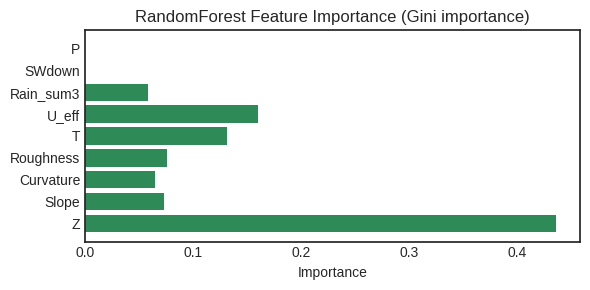

In [153]:
import matplotlib.pyplot as plt

feature_names = ["Z", "Slope", "Curvature", "Roughness", "T", "U_eff", "Rain_sum3", "SWdown", "P"]
importances = rf_baseline.feature_importances_

plt.figure(figsize=(6,3))
plt.barh(feature_names[:len(importances)], importances, color='seagreen')
plt.xlabel("Importance")
plt.title("RandomForest Feature Importance (Gini importance)")
plt.tight_layout()
plt.show()


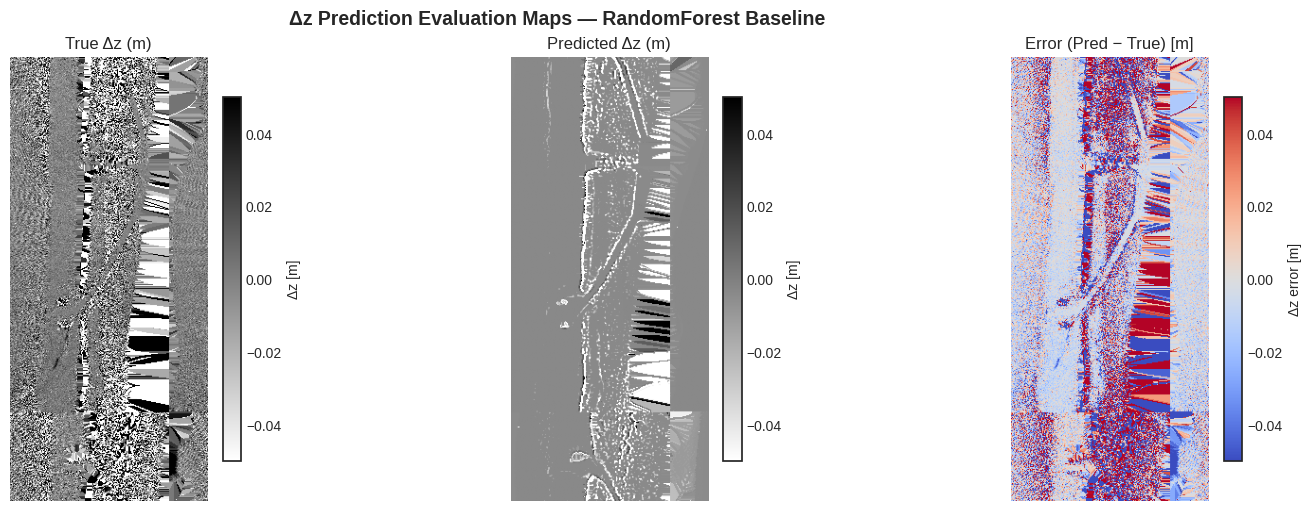

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# assume Z_true, Z_pred are (H, W)
vmin, vmax = -0.05, 0.05   # symmetric range for both true & predicted
err = Z_pred - Z_true

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# True Δz
im0 = axes[0].imshow(Z_true, cmap="binary", vmin=vmin, vmax=vmax)
axes[0].set_title("True Δz (m)")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Δz [m]")

# Predicted Δz
im1 = axes[1].imshow(Z_pred, cmap="binary", vmin=vmin, vmax=vmax)
axes[1].set_title("Predicted Δz (m)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Δz [m]")

# Error map (pred − true)
im2 = axes[2].imshow(err, cmap="coolwarm", vmin=-0.05, vmax=0.05)
axes[2].set_title("Error (Pred − True) [m]")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label="Δz error [m]")

for ax in axes:
    ax.axis("off")

plt.suptitle("Δz Prediction Evaluation Maps — RandomForest Baseline", fontsize=14, fontweight="semibold")
plt.show()


In [174]:
import numpy as np

# assume Z_pred, Z_true are [H, W]
Δz = Z_pred  # predicted change (error) or just Z_pred if you want absolute forecast

k = 10  # number of action cells to list

# For erosion (negative Δz)
flat_idx = np.argsort(Δz.ravel())[:k]
rows, cols = np.unravel_index(flat_idx, Δz.shape)
topk_erosion = [(int(r), int(c), float(Δz[r, c])) for r, c in zip(rows, cols)]

# For deposition (positive Δz)
flat_idx_pos = np.argsort(-Δz.ravel())[:k]
rows_p, cols_p = np.unravel_index(flat_idx_pos, Δz.shape)
topk_deposition = [(int(r), int(c), float(Δz[r, c])) for r, c in zip(rows_p, cols_p)]

print("Top-k erosion cells (row, col, Δz[m]):")
for item in topk_erosion:
    print(item)

print("\nTop-k deposition cells (row, col, Δz[m]):")
for item in topk_deposition:
    print(item)


Top-k erosion cells (row, col, Δz[m]):
(346, 154, -1.4567549169549867)
(345, 164, -1.4567549169549867)
(346, 153, -1.4479521863995555)
(346, 152, -1.4479521863995555)
(345, 162, -1.4479521863995555)
(345, 161, -1.4479521863995555)
(345, 160, -1.4479521863995555)
(345, 163, -1.4479521863995555)
(346, 151, -1.4479521863995555)
(345, 158, -1.4479521863995555)

Top-k deposition cells (row, col, Δz[m]):
(136, 78, 0.3970066877718903)
(383, 84, 0.23216021528884564)
(199, 76, 0.22566800465727785)
(315, 130, 0.18869930449242436)
(315, 129, 0.18749517871945806)
(140, 78, 0.17644396242929505)
(147, 78, 0.17426129048270567)
(315, 128, 0.17013181324339474)
(315, 125, 0.16647597745593953)
(315, 127, 0.16647597745593953)
